# Semantic segmentation using toy-MNIST
This notebook is written for a workshop/tutorial purpose. It does not use even `larcv`; you can run this notebook on google colaboratory with free K80 GPU.  Here's what we'll do in this notebook, and if it interests you please keep reading and share your feedback!

0. Make semantic segmentation toy data from MNIST
1. Design semantic segmentation network using U-Net + ResNet (we call U-ResNet).
2. Train U-ResNet

### Preparation?
If you are using [google colaboratory w/ free GPU](https://colab.research.google.com), make sure [you enable GPU option].

This notebook assumes you are familiar with [convolution operations](http://cs231n.stanford.edu) and [tensorflow](https://www.tensorflow.org) to some extent. For the latter, you should feel be familiar with [our MNIST example using tf.slim]. We will just use a lot of `tf.slim` APIs. You can start from all linked examples/resources if you want to prepare yourself well first.

### Import modules

In [1]:
from IPython.display import HTML, display
import commands,sys,os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

## Data generators & handlers

We will (modify and) use MNIST in this notebook. Let's also define some network constants we will use later. The comments in the code should give good enough descriptions except for, maybe, `IMAGE_SIZE` which is the size (number of pixels on one side) of a square image we will generate as our toy data for semantic segmentation training. You'll see an example of this image very shortly! 

In [2]:
# Download & extract mnist data set
from tensorflow.examples.tutorials.mnist import input_data
MNIST = input_data.read_data_sets('MNIST_data', one_hot=True)

# Constants used in this notebook
MNIST_SIZE       = 28   # MNIST image size
MNIST_NUM_CLASS  = 10   # Number of classes in MNIST (digits 0 to 9)
IMAGE_SIZE       = 128  # Segmentation data image size we will create
TRAIN_DATA_SIZE  = 5000 # Number of images in the whole train data
TEST_DATA_SIZE   = 1000 # Number of images in the whole test  data
TRAIN_BATCH_SIZE = 20   # Batch size for training input 
TEST_BATCH_SIZE  = 10   # Batch size for testing  input

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


If you want to try a larger segmentation image size, feel free to change `IMAGE_SIZE`. But you cannot make it smaller than MNIST_SIZE (or, actually, you can but then you might have an issue executing some cells below!).

### Data generator 
Next, we define 3 functions:
* `progress` is a utility function to display a "progress bar" :)
* `fill_mnist_segdata` is a core function that generates [`IMAGE_SIZE`,`IMAGE_SIZE`] semantic segmentation data + label. It also creates _weights_ for which we come back later.
* `make_mnist_segdata_big` is a function that generates a numpy array of semantic segmentation data. It internally calls `fill_mnist_segdata` to create individual image/label.

In [3]:
# Decorative progress bar
def progress(count, total, unit, message=''):
    return HTML("""
        <progress 
            value='{count}'
            max='{total}',
            style='width: 30%'
        >
            {count}
        </progress> {count}/{total} {unit} ({frac}%) ... {message}
    """.format(count=count, total=total, unit=unit, frac=int(float(count)/float(total)*100.),message=message))

# Create 1 segmentation data set ... image, label, and weights
def fill_mnist_segdata(big_image, big_label, big_weight, num_digits=6, train=True):
    source = MNIST.train
    if not train:
        source = MNIST.test
    
    image_size = big_image.shape[0]
    label = np.zeros([MNIST_SIZE]*2,dtype=np.float32)
    for _ in xrange(num_digits):
        index = np.random.randint(0,len(source.images))
        image = source.images[index]
        image = image.reshape([MNIST_SIZE]*2)

        label.fill(0)
        label_val = np.argmax(source.labels[index])+1
        label[np.where(image>0)] = label_val

        x_pos = int(np.random.randint(0,image_size-MNIST_SIZE))
        y_pos = int(np.random.randint(0,image_size-MNIST_SIZE))

        big_image[x_pos:x_pos+MNIST_SIZE,y_pos:y_pos+MNIST_SIZE] += image

        label_crop = big_label[x_pos:x_pos+MNIST_SIZE,y_pos:y_pos+MNIST_SIZE]
        label_crop[label>label_crop] = label_val
    
    vals, counts = np.unique(big_label,return_counts=True)
    for i, val in enumerate(vals):
        big_weight[np.where(big_label == val)] = 1. / counts[i] / len(vals)

# Create a whole segmentation data set for train/test
def make_mnist_segdata_big(data_size=5500,image_size=128,num_digits=6,train=True):
    print('Generating {data_size} images...'.format(data_size=data_size))  
    images  = np.zeros([data_size,image_size,image_size],dtype=np.float32)
    labels  = np.zeros([data_size,image_size,image_size],dtype=np.int64  )
    weights = np.zeros([data_size,image_size,image_size],dtype=np.float32)
    out = display(progress(0,data_size,'images'),display_id=True)
    for _ in range(data_size):
        image  = images  [_]
        label  = labels  [_]
        weight = weights [_]
        fill_mnist_segdata(image,label,weight,num_digits,train=train)
        out.update(progress(_,data_size,'images'))
    out.update(progress(data_size,data_size,'images'))
    print('done!')
    return images, labels, weights
  

Let's generate data set for _training_ and _testing_ the network. You can make `TRAIN_DATA_SIZE` and `TEST_DATA_SIZE` larger than what I set, but watch out on memory usage: many large images = big memory usage. `train` function argument decides whether data should be generated from `MNIST` _train_ set or _test_ set.

In [4]:
# Generate data sets
train_images, train_labels, train_weights = make_mnist_segdata_big(TRAIN_DATA_SIZE, train=True)
test_images,  test_labels,  test_weights  = make_mnist_segdata_big(TEST_DATA_SIZE,  train=False)

Generating 5000 images...


done!
Generating 1000 images...


done!


### What have we made?
... so what have we made? Easiest answer is to simply visualize :)

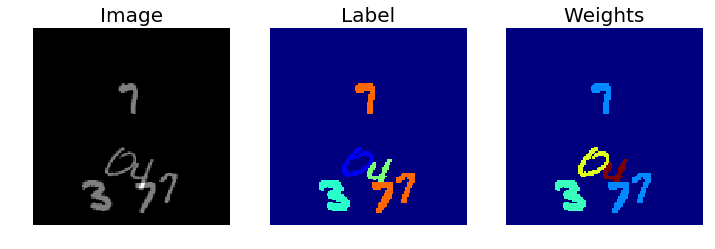

In [5]:
# Visualize a random entry
index = np.random.randint(0,len(train_images))
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,12),facecolor='w')
ax1.imshow(train_images[index],  interpolation='none',cmap='gray')
ax2.imshow(train_labels[index],  interpolation='none',cmap='jet',vmin=0,vmax=10)
ax3.imshow(train_weights[index], interpolation='none',cmap='jet')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax1.set_title('Image',fontsize=20)
ax2.set_title('Label',fontsize=20)
ax3.set_title('Weights',fontsize=20)
plt.show()

You're welcome! This is so clear! ... of course not! (sorry) and here is my guessed list of questions.

### What's semantic segmentation?
Right, let's start from there. "Semantic segmentation" is a technical jargon that represents a certain task/challenge in the field of computer vision where we are interested in labeling pixels in an image to indicate the location of pre-defined semantics (i.e. object categories). It's also often referred to as "pixel-level classification" instead of image-level classification. 

### What have we generated?
Functions we defined & executed randomly pick 6 MNIST images (one digit per image, centered in 28x28 pixels) and place them in a larger image of the size 128x128 pixels. We will train our network to correctly label individual digit's pixels in this image. This is what you see on the left of 3 images above.

We'll train our network with labels (supervised training), which is shown in the middle. In this toy data, an overlap of more than one digit is handled by respecting the label of higher digit values. No, there's no good reason to do this, but it serves the purpose of this notebook!

### What is "weight" image?
The following explanation may become much clearer when we define an optimization target (i.e. a metric to minimize in order to train the network). We will use a softmax loss (logistic multinominal regression) over 11 categories per pixel (10 digits + background pixels) computed over a batch of images. A loss for a batch can be a simple summation of all pixel's softmax loss. 

However, a distribution of pixel counts over semantics (i.e. 10 digits + background categories) is not flat. The background pixels occupy the majority portion of all pixels in each image. More over, since digits are randomly chosen to make an image, there is a variation of pixel counts per batch even among digit categories. A different pixel count per category can, therefore, bias loss calculation. Simply put, the background pixels occupies a large weight in the average loss value per batch of data. 

In order to compensate differences in pixel counts among semantics, we will weight our pixel-wise loss by a weighting factor that is simply an inverse of pixel counts per category. This means a loss weighting factor becomes small for a category with a large pixel count. As this weighting factor is computed per pixel, we store this data in an image format. This is what's shown on the right of 3 images above!

### tf.Dataset ... data handler
The whole dataset for this training exists on CPU RAM. Therefore we can use a simple `tf.data.Dataset` routine to construct our input data handlers. I won't explain the details of how `tf.data.Dataset` works here as it's not the intention of this notebook (see [tensorflow's description](https://www.tensorflow.org/programmers_guide/datasets)). I give a brief description of operations defined here after the next cell.

In [6]:
sess = tf.InteractiveSession()
with tf.variable_scope("train_input"):
    #Create a dataset tensor from the images and the labels
    train_dataset  = tf.data.Dataset.from_tensor_slices((train_images,train_labels,train_weights))
    train_dataset  = train_dataset.shuffle(buffer_size=5500,reshuffle_each_iteration=True).batch(TRAIN_BATCH_SIZE)
    train_iterator = train_dataset.make_initializable_iterator()
    # It is better to use 2 placeholders, to avoid to load all data into memory,
    # and avoid the 2Gb restriction length of a tensor.
    _batch_train_images  = tf.placeholder(tf.float32, [None, IMAGE_SIZE, IMAGE_SIZE])
    _batch_train_labels  = tf.placeholder(tf.int64,   [None, IMAGE_SIZE, IMAGE_SIZE])
    _batch_train_weights = tf.placeholder(tf.float32, [None, IMAGE_SIZE, IMAGE_SIZE])
    # Initialize the iterator
    sess.run(train_iterator.initializer, 
             feed_dict={_batch_train_images : train_images,
                        _batch_train_labels : train_labels,
                        _batch_train_weights: train_weights})

    # Neural Net Input
    batch_train_images, batch_train_labels, batch_train_weights = train_iterator.get_next()
    batch_train_images = tf.reshape(batch_train_images, [-1, IMAGE_SIZE, IMAGE_SIZE, 1])
    
tf.summary.image  ('image_example', batch_train_images,3)
tf.summary.image  ('label_example', tf.image.grayscale_to_rgb(tf.cast(batch_train_labels,tf.float32),'gray_to_rgb'),3)

with tf.variable_scope("test_input"):
    #Create a dataset tensor from the images and the labels
    test_dataset  = tf.data.Dataset.from_tensor_slices((test_images,test_labels,test_weights))
    test_dataset  = test_dataset.shuffle(buffer_size=1000,reshuffle_each_iteration=True).batch(TEST_BATCH_SIZE)
    test_iterator = test_dataset.make_initializable_iterator()
    # It is better to use 2 placeholders, to avoid to load all data into memory,
    # and avoid the 2Gb restriction length of a tensor.
    _batch_test_images  = tf.placeholder(tf.float32, [None, IMAGE_SIZE, IMAGE_SIZE])
    _batch_test_labels  = tf.placeholder(tf.int64,   [None, IMAGE_SIZE, IMAGE_SIZE])
    _batch_test_weights = tf.placeholder(tf.float32, [None, IMAGE_SIZE, IMAGE_SIZE])
    # Initialize the iterator
    sess.run(test_iterator.initializer, 
             feed_dict={_batch_test_images:  test_images,
                        _batch_test_labels:  test_labels,
                        _batch_test_weights: test_weights})

    # Neural Net Input
    batch_test_images,  batch_test_labels, batch_test_weights = test_iterator.get_next()
    batch_test_images  = tf.reshape(batch_test_images,  [-1, IMAGE_SIZE, IMAGE_SIZE, 1])

In above, we defined `train` and `test` data sets + _iterators_ which automatically handles shuffling and loading of data into our network. `batch_train_*` and `batch_test_*` are `tf.Tensor`s that hold a batch of data, label and weight images. So we can use them to construct a network. You'll see it soon.

## Design & construction of U-ResNet
Our U-ResNet architecture in this notebook is very simple, and it consists from 2 parts that we call _encoding_ and _decoding_ paths, a design following the original [U-Net](https://arxiv.org/abs/1505.04597). In our implementation, both path employes [classic ResNet](https://arxiv.org/pdf/1512.03385.pdf) modules. 

### ResNet module
This is implemented in `toy_resnet_module` function. We use one of the most classical design of ResNet, namely two convolution layers (each followed by batch normalization) with a short-cut connection. The shortcut connection is an identity mapping unless convolution layers change the tensor dimension, in which case the shortcut is made by 1x1 convolution. 

### Encoding path
Starting from the input image tensor, the first half of U-ResNet is a stuck of convolution layers that contract 2D spatial dimension of the tensor while encoding feature information in increasing feature map depth. This path starts with one normal convolution layer with (3,3) kernel and stride 1 followed by (2,2) max-pooling with stride 2. What follows is 2x4 ResNet modules, implemented by calling `double_toy_resnet` function 4 times. 

The first convolution layer of the every other ResNet module uses stride of 2, resulting in a contraction factor of 16 total. When the 2D spatial dimension is contracted, the feature dimension is expanded by a factor of 2. With the number of filters in the first layer being 32, the most contracted feature map has the dimension of (8,8,256).

As you may have noticed that the structure of the encoding path is identical to that of image classification. The intent of this encoding path is to extract a highly abstract feature information. In the process we lost the spatial resolution through pooling and stride 2 convolutions. The second half of U-ResNet, the decoding path, addresses how to interpolate acquired abstract feature information back into an image with high spatial resolution.

### Decoding path
The decoding path is the second half of U-ResNet, and implemented in `toy_uresnet` together with the encoding path. The decoding path is pretty much the mirror image of the encoding path with additional `slim.conv2d_transpose`. This is essentially an interpolation operation which expands the spatial dimension while contracting the feature depth. Being implemented as a neural network, this is a _learnable_ interpolation filter.

What comes next is the very core (and key) architecture of U-ResNet. After every interpolation filter, we concatennate feature maps of the same size from the encoding path. As there are 4 steps of contraction and interpolation, there are 4 concatennations. By doing so, the decoding path receives the most precise spatial information prior to pooling and stride operations. After each concatenation, this path employs 2 ResNet modules.

In [7]:
import tensorflow.python.platform
import tensorflow.contrib.layers as L
import tensorflow.contrib.slim as slim

def toy_resnet_module(input_tensor, num_outputs, trainable=True, kernel=(3,3), stride=1, scope='noscope'):

    fn_conv = slim.conv2d

    num_inputs  = input_tensor.get_shape()[-1].value
    with tf.variable_scope(scope):
        #
        # shortcut path
        #
        shortcut = None
        if num_outputs == num_inputs and stride ==1 :
            shortcut = input_tensor
        else:
            shortcut = slim.conv2d(inputs      = input_tensor,
                                   num_outputs = num_outputs,
                                   kernel_size = 1,
                                   stride      = stride,
                                   normalizer_fn = slim.batch_norm,
                                   activation_fn = None,
                                   trainable   = trainable,
                                   scope       = 'shortcut')
        #
        # residual path
        #
        residual = slim.conv2d(inputs      = input_tensor,
                               num_outputs = num_outputs,
                               kernel_size = kernel,
                               stride      = stride,
                               normalizer_fn = slim.batch_norm,
                               #activation_fn = None,
                               trainable   = trainable,
                               scope       = 'resnet_conv1')
        
        residual = slim.conv2d(inputs      = residual,
                               num_outputs = num_outputs,
                               kernel_size = kernel,
                               normalizer_fn = slim.batch_norm,
                               activation_fn = None,
                               trainable   = trainable,
                               scope       = 'resnet_conv2')
        
        return tf.nn.relu(shortcut + residual)

def double_toy_resnet(input_tensor, num_outputs, trainable=True, kernel=3, stride=1, scope='noscope'):

    with tf.variable_scope(scope):

        resnet1 = toy_resnet_module(input_tensor=input_tensor,
                                    trainable=trainable,
                                    kernel=kernel,
                                    stride=stride,
                                    num_outputs=num_outputs,
                                    scope='module1')
        
        resnet2 = toy_resnet_module(input_tensor=resnet1,
                                    trainable=trainable,
                                    kernel=kernel,
                                    stride=1,
                                    num_outputs=num_outputs,
                                    scope='module2')

        return resnet2

def toy_uresnet(input_tensor, num_class, reuse=False, trainable=True, base_filter=32, num_contraction=4):

    with tf.variable_scope('toy_uresnet', reuse=reuse):
    
        conv_feature_map={}
        net = input_tensor
        print('Input shape {:s}'.format(net.shape))

        # 1st conv layer normal
        net = slim.conv2d     (net, base_filter, 3, normalizer_fn=slim.batch_norm, trainable=trainable, scope='conv0')
        conv_feature_map[net.get_shape()[-1].value] = net
        print('Encoding step 0 shape {:s}'.format(net.shape))  

        net = slim.max_pool2d (net,              2, scope='maxpool0')    
        # encoding steps
        for step in range(num_contraction):
            num_outputs = base_filter * (2**(step+1))
            stride = 2
            if step == 0: stride = 1
            net = double_toy_resnet(net, num_outputs, trainable=trainable, stride=stride, scope='res{:d}'.format(step+1))
            conv_feature_map[net.get_shape()[-1].value] = net
            print('Encoding step {:d} shape {:s}'.format(step+1,net.shape))
        # decoding steps
        for step in range(num_contraction):
            num_outputs = net.get_shape()[-1].value / 2
            net = slim.conv2d_transpose(net, num_outputs, 3, stride=2, normalizer_fn=slim.batch_norm, trainable=trainable, scope='deconv{:d}'.format(step))
            net = tf.concat([net, conv_feature_map[num_outputs]], axis=len(net.shape)-1, name='concat{:d}'.format(step))
            net = double_toy_resnet(net, num_outputs, trainable=trainable, scope='conv{:d}'.format(step+num_contraction+1))
            print('Decoding {:d} shape {:s}'.format(step,net.shape))

        # final conv layer
        net = slim.conv2d(net, num_class, 3, normalizer_fn=slim.batch_norm, trainable=trainable, scope='lastconv')
        print('Final shape {:s}'.format(net.shape))  
        return net
 

### Building networks
For train and test data set, we make corresponding networks. The train network is what we train. The test network shares parameters with the train network (e.g. `reuse=True`) but operators are set to be un-trainable.

In [8]:
print('Building train net...')
train_net = toy_uresnet (batch_train_images, MNIST_NUM_CLASS+1, trainable=True,  reuse=False )

print('\nBuilding test net...')
test_net  = toy_uresnet (batch_test_images,  MNIST_NUM_CLASS+1, trainable=False, reuse=True  )

Building train net...
Input shape (?, 128, 128, 1)
Encoding step 0 shape (?, 128, 128, 32)
Encoding step 1 shape (?, 64, 64, 64)
Encoding step 2 shape (?, 32, 32, 128)
Encoding step 3 shape (?, 16, 16, 256)
Encoding step 4 shape (?, 8, 8, 512)
Decoding 0 shape (?, 16, 16, 256)
Decoding 1 shape (?, 32, 32, 128)
Decoding 2 shape (?, 64, 64, 64)
Decoding 3 shape (?, 128, 128, 32)
Final shape (?, 128, 128, 11)

Building test net...
Input shape (?, 128, 128, 1)
Encoding step 0 shape (?, 128, 128, 32)
Encoding step 1 shape (?, 64, 64, 64)
Encoding step 2 shape (?, 32, 32, 128)
Encoding step 3 shape (?, 16, 16, 256)
Encoding step 4 shape (?, 8, 8, 512)
Decoding 0 shape (?, 16, 16, 256)
Decoding 1 shape (?, 32, 32, 128)
Decoding 2 shape (?, 64, 64, 64)
Decoding 3 shape (?, 128, 128, 32)
Final shape (?, 128, 128, 11)


Next, let us define operations for train and test networks. Let's start with the test network where we measure the performance. Here is a brief description of operations.

* `prediction` ... pixel label predicted by the network (argmax of last layer's activation).
* `accuracy_allpx` ... the mean accuracy of predicted pixel labels for all pixels, averaged over a batch of data.
* `accuracy_valpx` ... the mean accuracy of predicted pixel labels for non-zero pixels, averaged over a batch of data.
* `softmax` ... an image (pixel-map) of softmax probability distribution over semantics

In [9]:
with tf.variable_scope('analysis'):
    prediction     = tf.argmax(test_net,3)
    accuracy_allpx = tf.reduce_mean(tf.cast(tf.equal(prediction, batch_test_labels),tf.float32))
    nonzero_idx    = tf.where(tf.reshape(batch_test_images, [-1, IMAGE_SIZE, IMAGE_SIZE]) > tf.to_float(0.) )
    nonzero_label  = tf.gather_nd(batch_test_labels, nonzero_idx)
    nonzero_pred   = tf.gather_nd(tf.argmax(test_net, 3), nonzero_idx)
    accuracy_valpx = tf.reduce_mean(tf.cast(tf.equal(nonzero_label, nonzero_pred),tf.float32))
    softmax        = tf.nn.softmax(logits=test_net)

tf.summary.scalar ('accuracy_allpx', accuracy_allpx)
tf.summary.scalar ('accuracy_valpx', accuracy_valpx)


<tf.Tensor 'accuracy_valpx:0' shape=() dtype=string>

For the train net, we will define...

* `loss` ... weighted sum of softmax (multinominal logistic regression) loss from all pixels per image, averaged over a batch of images.
* `train` ... op for training a network using a batch of data. The learning rate can be changed/set on the fly by using tf.placeholder

In [10]:
with tf.variable_scope('train'):
    loss_pixel     = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=batch_train_labels, logits=train_net)
    loss_weighted  = tf.multiply(loss_pixel, batch_train_weights)
    loss           = tf.reduce_mean(tf.reduce_sum(tf.reshape(loss_weighted, [-1, int(IMAGE_SIZE**2)]),axis=1))

    learning_rate  = tf.placeholder(tf.float32,[])
    train          = tf.train.AdamOptimizer(learning_rate).minimize(loss)

tf.summary.scalar ('loss', loss)


<tf.Tensor 'loss:0' shape=() dtype=string>

## Train
Let's train U-ResNet. We first create a log writer which saves the graph structure and `tf.summary` operations' output so that we can visualize with tensorboard later. Separately we also keep loss and accuracies calculations during training into an array for plotting. Although they are saved in tensorboard log, this way we can plot them in this notebook as well.

In [11]:
# Create log monitor
if not os.path.isdir('tb_log'): os.makedirs('tb_log')
log_writer = tf.summary.FileWriter('tb_log')
log_writer.add_graph(sess.graph)
summary_op = tf.summary.merge_all()
# Initialize everything
sess.run(tf.global_variables_initializer())

class train_log:
    pass
log = train_log()
log.train_loss   = []
log.test_acc_val = []
log.test_acc_all = []
log.test_steps   = []

Next, let us define two functions: `imshow_test` to visualize the network's performance on 1 test image, and `plot_log` to visualize the loss and accuracy curves as a function of training steps.

In [12]:
def imshow_test(num_images=None):
    ops = [batch_test_images,batch_test_labels,prediction,softmax]
    try:
        images, labels, preds, probs = sess.run(ops)
    except tf.errors.OutOfRangeError:
        
        # Reload the iterator when it reaches the end of the dataset
        sess.run(test_iterator.initializer,
                 feed_dict={_batch_test_images: test_images,
                            _batch_test_labels: test_labels})
        images, labels, preds, probs = sess.run(ops)
    if num_images is None or num_images > len(images):
        num_images = len(images)
    for index in range(num_images):
        fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,12),facecolor='w')
        ax1.imshow(images[index].reshape([IMAGE_SIZE,IMAGE_SIZE]), interpolation='none',cmap='gray')
        ax2.imshow(labels[index].reshape([IMAGE_SIZE,IMAGE_SIZE]), interpolation='none',cmap='jet',vmin=0,vmax=10)
        ax3.imshow(preds[index].reshape([IMAGE_SIZE,IMAGE_SIZE]),  interpolation='none',cmap='jet',vmin=0,vmax=10)
        ax1.axis('off')
        ax2.axis('off')
        ax3.axis('off')
        ax1.set_title('Image',fontsize=20)
        ax2.set_title('Label',fontsize=20)
        ax3.set_title('Prediction',fontsize=20)
        plt.show()
        
def plot_log(log):
    fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
    ax1.plot(np.arange(0,len(log.train_loss)),log.train_loss,
                       linewidth=2,
                       label='Loss',color='b')
    ax1.set_xlabel('Iterations',fontweight='bold',fontsize=24,color='black')
    ax1.tick_params('x',colors='black',labelsize=18)
    ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
    ax1.tick_params('y',colors='b',labelsize=18)

    ax2 = ax1.twinx()
    ax2.plot(log.test_steps,1.- np.array(log.test_acc_val),
             marker='o',linestyle='',
             color='orange',label='Acc. Nonzero Px')
    ax2.plot(log.test_steps,1.- np.array(log.test_acc_all),color='magenta',label='Acc. All px')
    ax2.set_ylabel('Error Rate', fontsize=24, fontweight='bold',color='r')
    ax2.tick_params('y',colors='r',labelsize=18)
    ax2.set_ylim(0.,0.2)

    plt.grid()
    plt.show()

Just for fun, before we start training, let's take a look at how the network performs on a test image using `imshow_test`.

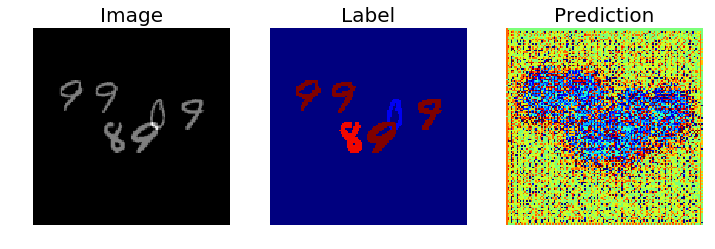

In [13]:
imshow_test(1)

As expected, pretty bad! 

Finally define a function to run the training. We make the arguments to this function such that it runs a certain number of training steps (`num_steps`) with a specified learning rate (`lr`). Also the network performance (accuracy) is computed periodically. The period is in number of train steps and defined by the argument `display_cycle`.

In [14]:
# Training
def train_loop(num_steps,log,lr=0.001,display_cycle=20):
    
    previous_steps = len(log.train_loss)
    print('Running train iterations {:d} => {:d}!'.format(previous_steps,previous_steps+num_steps))
    
    log.train_loss = np.append(log.train_loss, np.zeros([num_steps],dtype=np.float32))
    epoch_in_steps = float(TRAIN_DATA_SIZE) / float(TRAIN_BATCH_SIZE)
    step_in_epochs = 1./epoch_in_steps
    current_epoch  = int(previous_steps / epoch_in_steps) - 1
    full_report    = display(progress(previous_steps,previous_steps+num_steps,'steps'),display_id=True)
    epoch_report   = display(progress(0, epoch_in_steps, 'steps'),display_id=True)
    for step in range(num_steps):

        global_step = step + previous_steps
        
        try:
            # Run optimization
            _,log.train_loss[global_step] = sess.run([train,loss],feed_dict={learning_rate: lr})
        except tf.errors.OutOfRangeError:
            # Reload the iterator when it reaches the end of the dataset
            sess.run(train_iterator.initializer,
                     feed_dict = {_batch_train_images: train_images,
                                  _batch_train_labels: train_labels})
            _,log.train_loss[global_step] = sess.run([train,loss],feed_dict={learning_rate: lr})

        steps_this_epoch = int((global_step+1) - epoch_in_steps * current_epoch)
        if int((global_step+1) * step_in_epochs) > current_epoch:
            # imshow test @ epoch boundary    
            current_epoch += 1
            if current_epoch%2 == 0:
                imshow_test(1)
            #imshow_test(1)
            #report = display(progress(steps_this_epoch,int(epoch_in_steps),'steps'),display_id=True)

        message = 'Epochs {:d}/{:.2f}'.format(current_epoch,(previous_steps+num_steps)/epoch_in_steps)
        full_report.update(progress(global_step,previous_steps+num_steps,'steps',message))
        if len(log.test_acc_val)<1:
            message = 'Epoch {:d} loss {:.4f} '.format(current_epoch,log.train_loss[global_step])
            epoch_report.update(progress(steps_this_epoch,int(epoch_in_steps),'steps',message))
        else:
            message = 'Epoch {:d} loss {:.4f} ... last test accuracy {:.3f} ... {:.3f}'
            message = message.format(current_epoch,
                                     log.train_loss[global_step],log.test_acc_all[-1],log.test_acc_val[-1])
            epoch_report.update(progress(steps_this_epoch,int(epoch_in_steps),'steps',message))
        if (global_step+1) % display_cycle == 0:
            # Calculate batch loss and accuracy
            # (note that this consume a new batch of data)
            try:
                acc_val, acc_all = sess.run([accuracy_valpx, accuracy_allpx])
            except tf.errors.OutOfRangeError:
                # Reload the iterator when it reaches the end of the dataset
                sess.run(test_iterator.initializer,
                         feed_dict={_batch_test_images: test_images,
                                    _batch_test_labels: test_labels})
                acc_val, acc_all = sess.run([accuracy_valpx, accuracy_allpx])
            log.test_acc_val.append(acc_val)
            log.test_acc_all.append(acc_all)
            log.test_steps.append(global_step+1)

Finally we're all set. Let's first run 10000 steps with the default learning rate of an optimizer. In our case, it's 0.001 for `AdamOptimizer`. 10,000 steps corresponds to 200,000 images or 40 epochs (since `TRAIN_BATCH_SIZE` is 20 and `TRAIN_DATA_SIZE` is 5,000).

Running train iterations 0 => 10000!


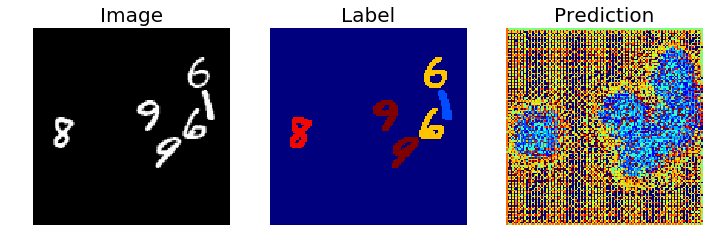

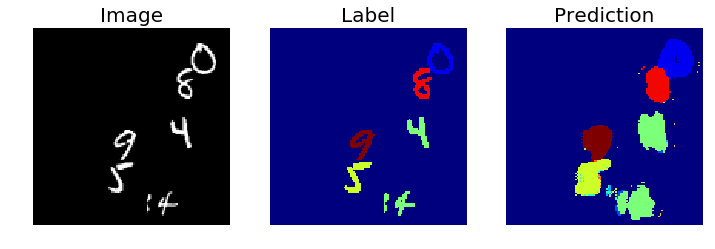

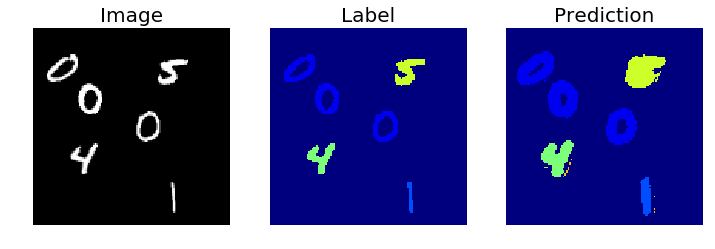

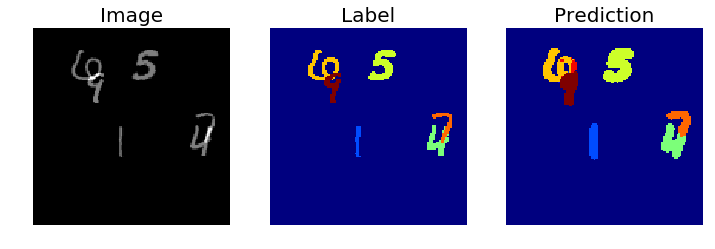

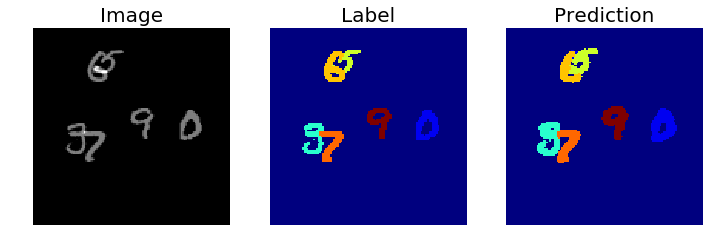

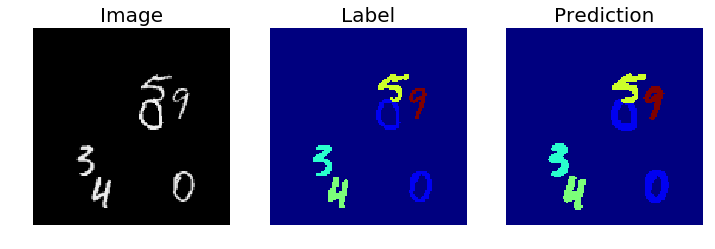

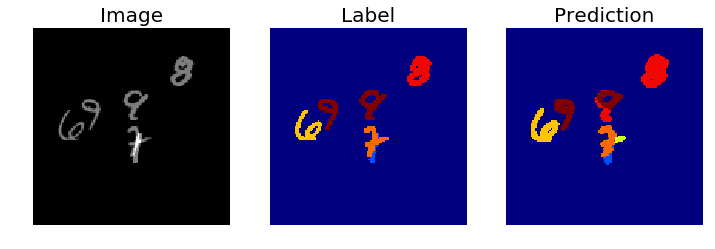

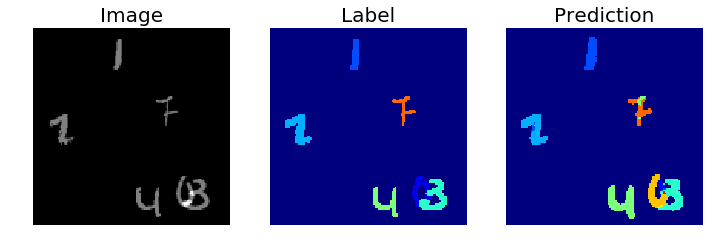

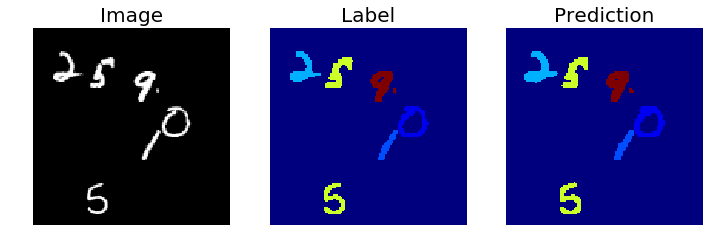

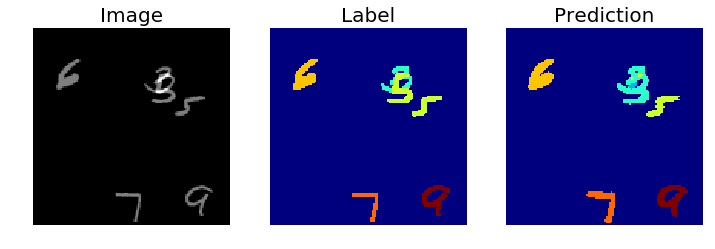

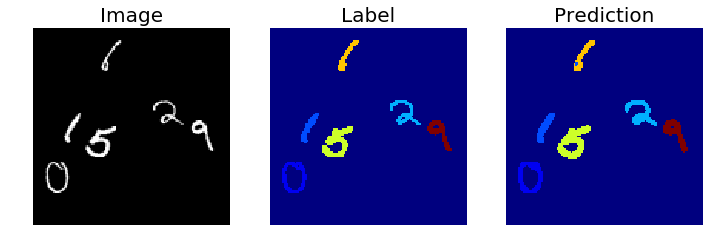

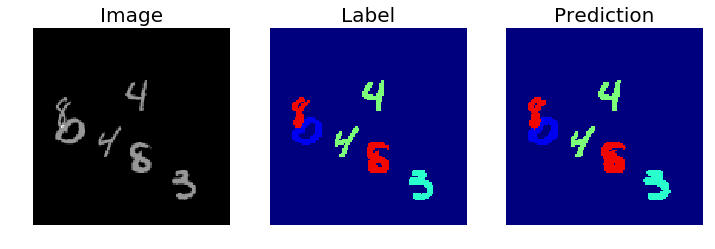

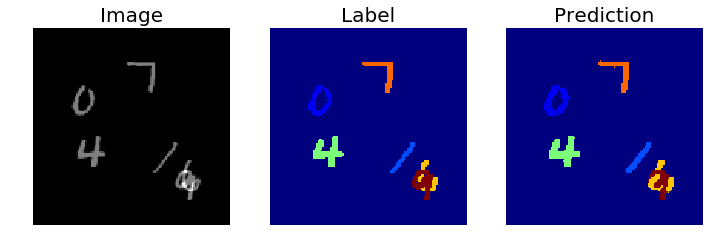

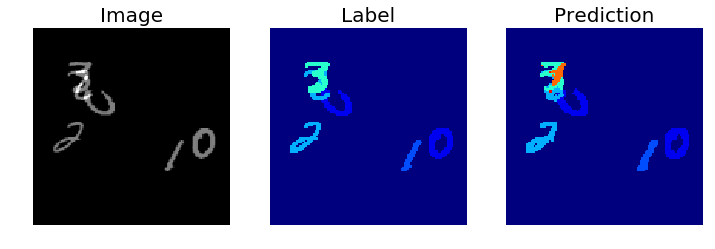

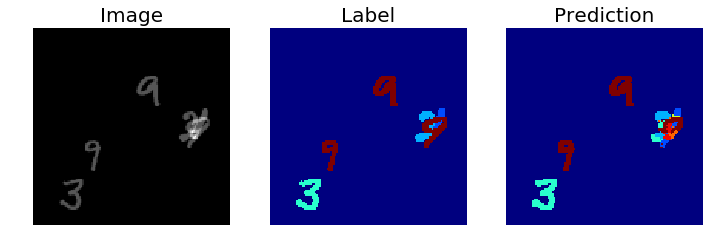

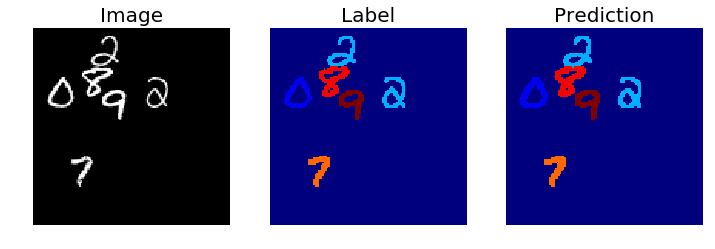

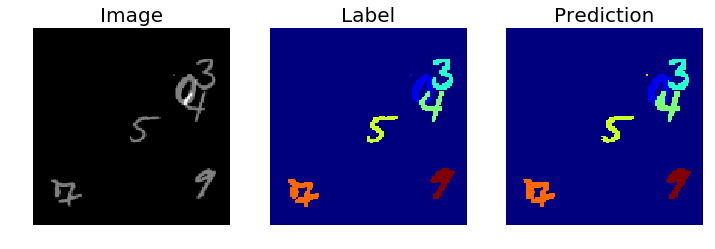

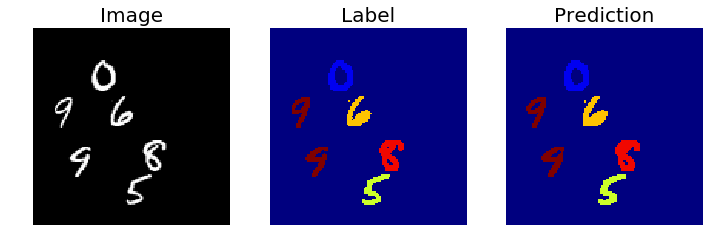

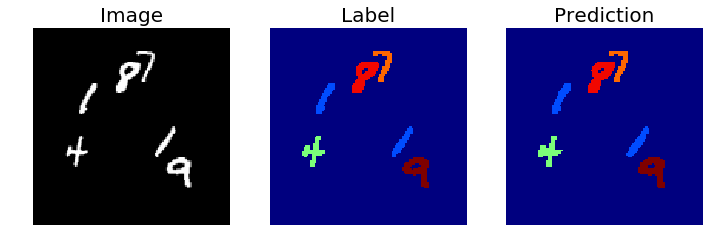

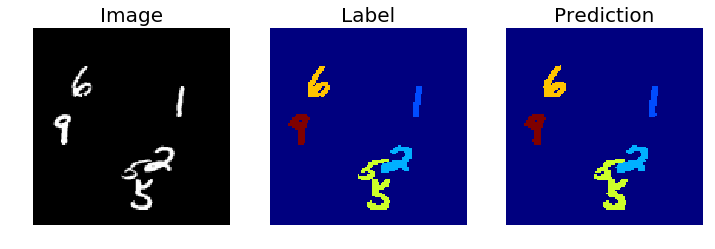

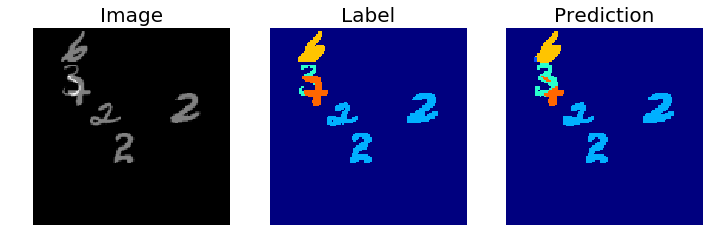

In [15]:
train_loop(10000,log,lr=0.001)

Plotting the learning curves...

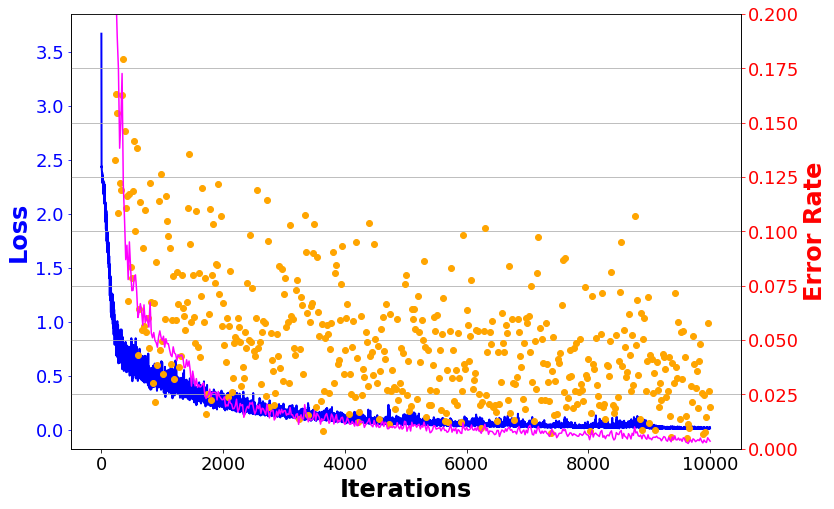

In [16]:
plot_log(log)

It looks like it can learn further, but this is enough for now. Let's take a look at 3 inference images

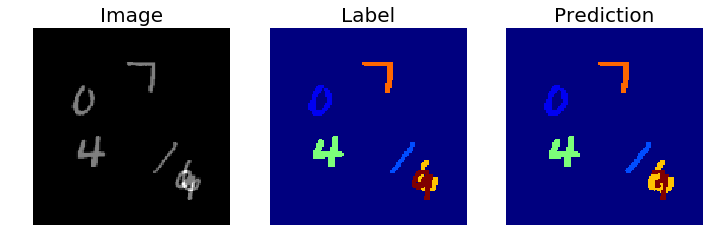

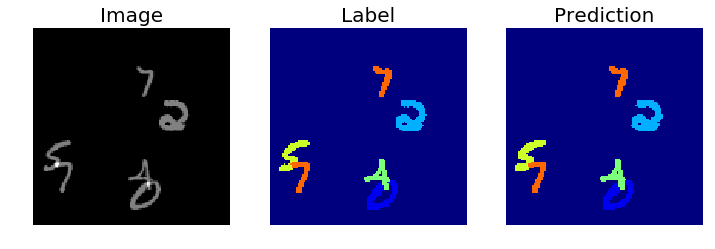

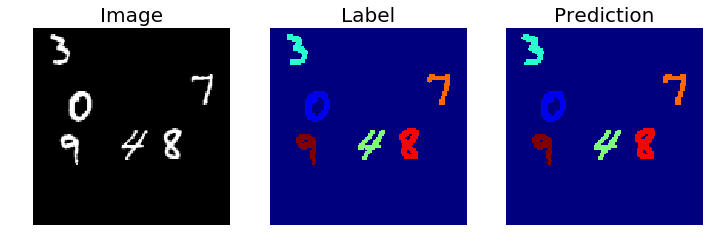

In [17]:
imshow_test(3)

## Closing remarks
In this notebook we trained U-ResNet on a toy segmentation data sample generated from MNIST. Hopefully this was educative and now you are motivated to attack something that may be useful, like [PASCAL](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html) for photographs or [our public data](http://deeplearnphysics.org/DataChallenge). 